In [95]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Monday 11/30, 11:59 PM PST

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

## Disclaimer about `sns.distplot()`

This project was designed for a slightly older version of seaborn, which does not support the new `displot` method taught in Lecture 9. Instead, in this project will occasionally call `distplot` (with a `t`). As you may have noticed in several of the previous assignments, use of the `distplot` function triggers a deprecation warning to notify the user that they should replace all deprecated functions with the updated version. Generally, warnings should not be suppressed but we will do so in this assignment to avoid cluttering.

See the seaborn documentation on [distributions](https://seaborn.pydata.org/tutorial/distributions.html) and [functions](https://seaborn.pydata.org/tutorial/function_overview.html) for more details.

In [96]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 3
10 | 15
Total | 55

# Part I - Initial Analysis

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [98]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head(20)

Using version already downloaded: Mon Nov 16 01:55:49 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Nov 16 01:55:50 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
5,5,Subject: Five\n,url: http://diveintomark.org/archives/2002/10/...,0
6,6,Subject: [SAdev] [Bug 1006] Spamassassin's bui...,http://www.hughes-family.org/bugzilla/show_bug...,0
7,7,Subject: One of a kind Money maker! Try it for...,------000000000000000000000\n content-type: te...,1
8,8,Subject: freshrpms.net resources (was Re: use ...,"once upon a time, brian wrote :\n \n > yeah...",0
9,9,Subject: use of base image / delta image for a...,"hi,\n \n i was inspired by a mode of operation...",0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [99]:
original_training_data['subject'] = original_training_data['subject'].fillna('')
test['subject'] = test['subject'].fillna('')
original_training_data.isna().sum(), test.isna().sum()

(id         0
 subject    0
 email      0
 spam       0
 dtype: int64,
 id         0
 subject    0
 email      0
 dtype: int64)

In [100]:
grader.check("q1a")

All tests passed!

### Question 1b

In the cell below, print the text of the `email` field for the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [101]:
spam_array = original_training_data['spam'] == 1 #for checking which one is first spam and ham
first_ham = original_training_data.iloc[0, 2]
first_spam = original_training_data.iloc[2, 2]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [102]:
grader.check("q1b")

All tests passed!

<!-- BEGIN QUESTION -->

### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->

It seems like the spam email is formatted as a HTML format, while the ham is not. Also, there are new blank lines in the ham, while the spam is compacted with no new blank lines.

<!-- END QUESTION -->



## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [103]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [104]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for t in texts:
        arr = []
        for w in words:
            if w in t:
                arr.append(1)
            else:
                arr.append(0)
        indicator_array.append(arr)
    return np.array(indicator_array)

In [105]:
grader.check("q2")

All tests passed!

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](images/training_conditional_proportions.png)

You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [106]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<!-- BEGIN QUESTION -->

### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->

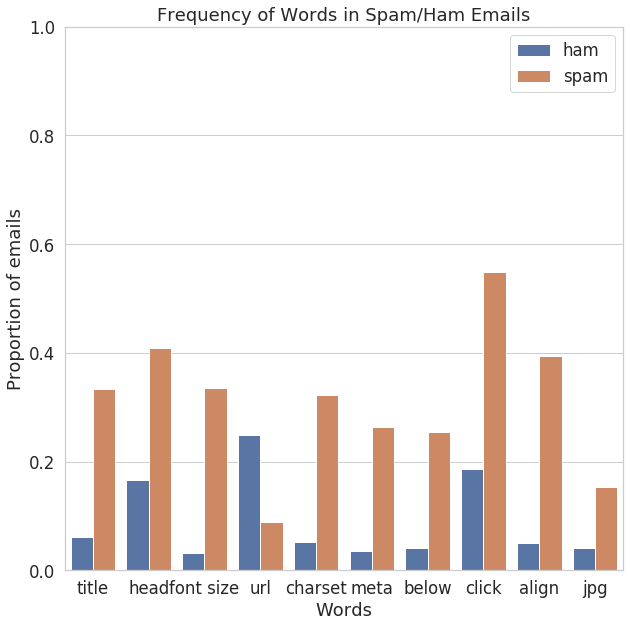

In [107]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ['title', 'head', 'font size', 'url', 'charset', 'meta', 'below', 'click', 'align', 'jpg']
texts = train['email']
new_table = pd.DataFrame(words_in_texts(words, texts))
new_table.columns = words
new_table["spam"] = train['spam']
new_table = new_table.melt("spam")
new_table['spam'] = new_table['spam'].replace({0: "ham", 1: "spam"})
plt.figure(figsize=(10, 10))
plt.ylim(0, 1)
ax = sns.barplot(x = 'variable', y = 'value', hue = 'spam', data=new_table, ci = None)
ax.legend_.set_title(None)
ax.set(xlabel='Words', ylabel='Proportion of emails')
ax.set_title("Frequency of Words in Spam/Ham Emails")
plt.savefig('myversionfrequnency.png');

<!-- END QUESTION -->



When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<!-- BEGIN QUESTION -->

### Question 3b

![training conditional densities](images/training_conditional_densities.png)

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->

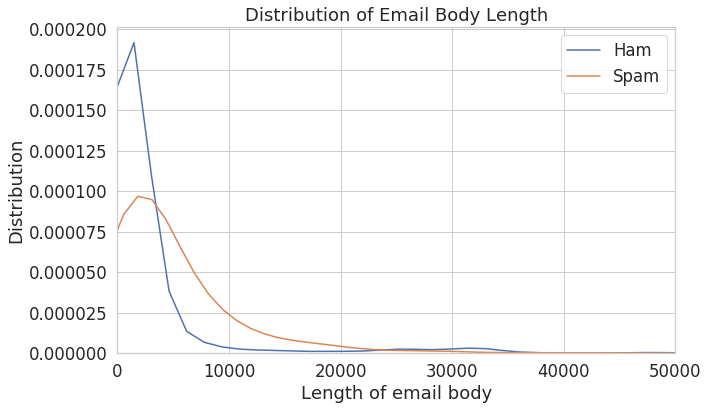

In [108]:
train['length'] = train['email'].str.len().astype(float)
train['type'] = new_table['spam'].replace({0: "ham", 1: "spam"})
spam = train[train['type'] == 'spam']
ham = train[train['type'] == 'ham']
plt.figure(figsize=(10, 6))
spamhamdens = sns.distplot(ham, x = ham['length'], hist = False).set_xlim(0, 50000)
sns.distplot(spam, x = spam['length'], hist = False)
plt.xlim(0, 50000)
plt.title('Distribution of Email Body Length')
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.legend(labels = ['Ham', 'Spam']);
plt.savefig('training_conditional_densities.png')

<!-- END QUESTION -->



# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of only 0's and 1's). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [109]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [110]:
grader.check("q4")

All tests passed!

### Question 5

Now that we have matrices, we can build a model with `scikit-learn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.75$

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [111]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
y_train_predict = model.predict(X_train)

training_accuracy = np.sum(y_train_predict == Y_train) / len(Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [112]:
grader.check("q5")

All tests passed!

## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (feel free to hard code your answers for this part):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [113]:
zero_predictor_fp = 0
zero_predictor_fn = train[train['spam'] == 1].count()[0]
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [114]:
grader.check("q6a")

All tests passed!

### Question 6b

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

7513

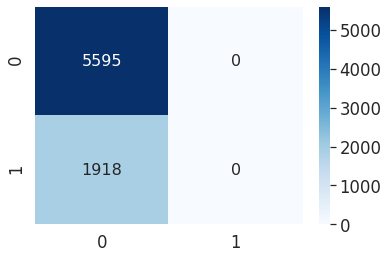

In [115]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train['spam'], np.zeros(train['spam'].count()))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})
tn = np.sum(train['spam'] == np.zeros(train['spam'].count()))
train['spam'].count()

In [116]:
zero_predictor = np.zeros(train['spam'].count())
tp = np.sum((train['spam'] == 1) & (zero_predictor == 1))
tn = np.sum((train['spam'] == 0) & (zero_predictor == 0))
fn = np.sum((train['spam'] == 1) & (zero_predictor == 0))
zero_predictor_acc = (tp+tn)/train['spam'].count()
zero_predictor_recall = tp/(tp+fn)
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0.0)

In [117]:
grader.check("q6b")

All tests passed!

<!-- BEGIN QUESTION -->

### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

We calculate FP because we want to know how many we predict 1(spam) but in fact a 0(ham). Fn for knowing how many we predict 0(ham) but in fact a 1(spam). Accuracy for what proportion of points did our zero predictor classify correctly. However, accuracy doesn't tell the full story, so we need recall to get to know of all the emails that were actually spam(1), what proportion were actually spam(1) to get a better gasp on our zero predictor.

<!-- END QUESTION -->

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

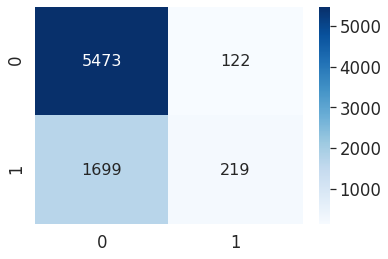

In [118]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(train['spam'], y_train_predict)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})

In [119]:
tp2 = np.sum((train['spam'] == 1) & (y_train_predict == 1))
fp2 = np.sum((train['spam'] == 0) & (y_train_predict == 1))
fn2 = np.sum((train['spam'] == 1) & (y_train_predict == 0))
tn2 = np.sum((train['spam'] == 0) & (y_train_predict == 0))
logistic_predictor_precision = tp2/(tp2+fp2)
logistic_predictor_recall = tp2/(tp2+fn2)
logistic_predictor_far = fp2/(fp2+tn2)

In [120]:
grader.check("q6d")

All tests passed!

<!-- BEGIN QUESTION -->

### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->

There are more false positive and less false negative when using the logistic regression classifier.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

1. Our logistic regression classifier got 75.76% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->

1.) It increases around 1% of the accuracy if we use the logistic regression. Though the difference is not huge, by using the logistic regression classifier, we are also predicting both of the classes, not just one like what the zero predictor did which it just predicts the 0 class. By using the logistic regression, it gives us a full picture on the predictions, like how well we are predicting spams within the emails, and how well we are predicting hams among the emails.

2.) Business, money, and offer seem to be also very prevalent in ham emails, thus making this classifier performing poorly.

3.) I would prefer the logistic regression classifier because it give a full story especially in cases with high class inbalance. The zero predictor is only predicting on ham emails, but it is not predicting well in the spam emails. As we can see, the recall is 0 for the zero predictor, which of all the observations that were actually 1, we did poorly on predicting howmany of them are actually 1(spam). Even though the recall when using the logistic is still not as good, but at least it is better than the zero predictor's.

<!-- END QUESTION -->



# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on 70% of the test set when submitting to Gradescope, but we will be evaluating your model on the entire test set so try to score slightly above 88% on gradescope if you can.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much.

---

In [121]:
#READ THIS
#There are a lot of fixing and improving below this, and I keep them as records of my path to my final model.
#If want to see my final approach to my final model, you can skip to cell 62.

In [122]:
train_copy = train.copy()
val_copy = val.copy()
train_copy['email length'] = train_copy['email'].str.len()
train_copy['title length'] = train_copy['subject'].str.len()
val_copy['email length'] = val_copy['email'].str.len()
val_copy['title length'] = val_copy['subject'].str.len()

In [123]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_cal(y, y_hat):
    tp = np.sum((y == 1) & (y_hat == 1))
    fp = np.sum((y == 0) & (y_hat == 1))
    fn = np.sum((y == 1) & (y_hat == 0))
    tn = np.sum((y == 0) & (y_hat == 0))
    accuracy = (tp+tn)/y.count()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tpr = fp/(fp+tn)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("False positive rate: ", fpr)
    print("True positive rate: ", tpr)
    return

In [124]:
words2 = ['title', 'head', 'font size', 'url', 'charset', 'meta', 'below', 'click', 'align']
texts2 = train_copy['email']
words_in_texts(words2, texts2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [125]:
#Added one new feature(email length) to the data set
#X_train_2 = pd.DataFrame(words_in_texts(words2, texts2))
#X_train_2['email length'] = train_copy['length']
#Y_train_2 = train_copy['spam']
#model2 = LogisticRegression()
#model2.fit(X_train_2, Y_train_2)
#y_train_predict_2 = model2.predict(X_train_2)
#training_accuracy2 = np.sum(y_train_predict_2 == Y_train_2) / len(Y_train_2)
#print("Training Accuracy: ", training_accuracy2)
#X_train_2

In [126]:
#cm3 = confusion_matrix(Y_train_2, y_train_predict_2)
#sns.heatmap(cm3, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})

In [127]:
#My first version
#confusion_matrix_cal(Y_train_2, y_train_predict_2)

In [128]:
#This is our first model from previous questions
#confusion_matrix_cal(Y_train, y_train_predict)

In [129]:
#Trying my first version on the validation set, added the email length column to val
#X_val = pd.DataFrame(words_in_texts(words2, val_copy['email']))
#X_val['email length'] = val_copy['email length'].reset_index().iloc[:, 1]
#Y_val = val_copy['spam']
#model_val = LogisticRegression()
#model_val.fit(X_val, Y_val)
#y_val_predict = model_val.predict(X_val)
#val_accuracy = np.sum(y_val_predict == Y_val) / len(Y_val)
#print("Training Accuracy: ", val_accuracy)

In [130]:
##Trying my first version on the validation set
#confusion_matrix_cal(Y_val, y_val_predict)

In [131]:
#Confusion matrix for our validation set applied by version 1 model
#cm_val = confusion_matrix(Y_val, y_val_predict)
#sns.heatmap(cm_val, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})

In [132]:
#My second version, added email length and title length
#texts3 = train_copy['email']
#X_train_3 = pd.DataFrame(words_in_texts(words2, texts3))
#X_train_3['email length'] = train_copy['email length']
#X_train_3['title length'] = train_copy['title length']
#Y_train_3 = train_copy['spam']
#model3 = LogisticRegression()
#model3.fit(X_train_3, Y_train_3)
#y_train_predict_3 = model3.predict(X_train_3)
#training_accuracy3 = np.sum(y_train_predict_3 == Y_train_3) / len(Y_train_3)
#print("Training Accuracy: ", training_accuracy2)
#confusion_matrix_cal(Y_train_3, y_train_predict_3)

In [133]:
#cm4 = confusion_matrix(Y_train_3, y_train_predict_3)
#sns.heatmap(cm3, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})

In [134]:
#My third version, adding the counts of exclamation to my second version
#First need to add columns to the training and validation sets
train_copy['Exclamation counts'] = train_copy['email'].str.count("!")
#val['Exclamation counts'] = val['email'].str.count("!")
#Now we train the data
#texts3 = train_copy['email']
#X_train_4 = pd.DataFrame(words_in_texts(words2, texts3))
#X_train_4['email length'] = train_copy['email length']
#X_train_4['title length'] = train_copy['title length']
#X_train_4['Exclamation counts'] = train_copy['email'].str.count("!")
#Y_train_4 = train_copy['spam']
#model4 = LogisticRegression()
#model4.fit(X_train_4, Y_train_4)
#y_train_predict_4 = model4.predict(X_train_4)
#training_accuracy4 = np.sum(y_train_predict_4 == Y_train_4) / len(Y_train_4)
#print("Training Accuracy: ", training_accuracy4)
#confusion_matrix_cal(Y_train_4, y_train_predict_4)

In [135]:
train_copy['Slash counts'] = train_copy['email'].str.count('\n')
train_copy['Exclamation in title'] = train_copy['subject'].str.count('!')
train

,id,subject,email,spam,length,type
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641.0,ham
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713.0,ham
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399.0,ham
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435.0,ham
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857.0,ham
...,...,...,...,...,...,...
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0,465.0,ham
7509,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1,7054.0,spam
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0,1732.0,ham
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0,1098.0,ham


In [136]:
#copy = train.copy()
#copy = copy.groupby(by= 'type', as_index = False).sum().drop(columns = ['id', 'spam', 'length'])
#sns.barplot(x = 'type', y ='title length',  data = copy, ci=None)

In [137]:
#My fourth version, adding the counts of exclamation counts in title to my third version
#First need to add columns to the training and validation sets
#Now we train the data
#texts3 = train_copy['email']
#X_train_5 = pd.DataFrame(words_in_texts(words2, texts3))
#X_train_5['email length'] = train_copy['email length']
#X_train_5['title length'] = train_copy['title length']
#X_train_5['Exclamation counts'] = train_copy['email'].str.count("!")
#X_train_5['Exclamation in title'] = train_copy['subject'].str.count("!")
#Y_train_5 = train_copy['spam']
#model5 = LogisticRegression()
#model5.fit(X_train_5, Y_train_5)
#y_train_predict_5 = model5.predict(X_train_5)
#confusion_matrix_cal(Y_train_5, y_train_predict_5)

In [138]:
#Testing the validation dataset with my fourth version model
#val_copy['Exclamation in title'] = val_copy['subject'].str.count("!")
#X_val2 = pd.DataFrame(words_in_texts(words2, val_copy['email']))
#X_val2['email length'] = val_copy['email length'].reset_index().iloc[:, 1]
#X_val2['title length'] = val_copy['title length'].reset_index().iloc[:, 1]
#X_val2['Exclamation counts'] = val_copy['email'].str.count("!").reset_index().iloc[:, 1]
#X_val2['Exclamation in title'] = val_copy['subject'].str.count("!").reset_index().iloc[:, 1]
#Y_val2 = val_copy['spam']
#model_val2 = LogisticRegression()
#model_val2.fit(X_val2, Y_val2)
#val2_predict = model_val2.predict(X_val2)
#confusion_matrix_cal(Y_val2, val2_predict)

In [139]:
train_copy['Reply counts'] = train_copy['subject'].str.count('Re')

In [140]:
#My fifth version, adding the reply counts my fourth version
#First need to add columns to the training and validation sets
#Now we train the data
texts3 = train_copy['email']
X_train_6 = pd.DataFrame(words_in_texts(words2, texts3))
X_train_6['email length'] = train_copy['email length']
X_train_6['title length'] = train_copy['title length']
X_train_6['Exclamation counts'] = train_copy['email'].str.count("!")
X_train_6['Exclamation in title'] = train_copy['subject'].str.count("!")
X_train_6['Reply counts'] = train_copy['subject'].str.count("Re")
Y_train_6 = train_copy['spam']
model6 = LogisticRegression()
model6.fit(X_train_6, Y_train_6)
y_train_predict_6 = model6.predict(X_train_6)
confusion_matrix_cal(Y_train_6, y_train_predict_6)

Accuracy:  0.8775455876480767
Precision:  0.8389945652173914
Recall:  0.6438998957247133
False positive rate:  0.042359249329758715
True positive rate:  0.042359249329758715


In [141]:
#Testing the validation dataset with my fifth version model
val_copy['Reply counts'] = val_copy['subject'].str.count("Re")
X_val3 = pd.DataFrame(words_in_texts(words2, val_copy['email']))
X_val3['Reply counts'] = val_copy['subject'].str.count("Re").reset_index().iloc[:, 1]
Y_val3 = val_copy['spam']
model_val3 = LogisticRegression()
model_val3.fit(X_val3, Y_val3)
val3_predict = model_val3.predict(X_val3)
confusion_matrix_cal(Y_val3, val3_predict)

Accuracy:  0.8682634730538922
Precision:  0.8294117647058824
Recall:  0.6351351351351351
False positive rate:  0.04730831973898858
True positive rate:  0.04730831973898858


In [142]:
#My sixth verion model which added the counts of uppercase letters in subject and email, 
#dollarsigns in subject, and removed exclamation counts in email
#this is the function to count the total number of uppercase letters in a column for each row
import re
def count_upper(column):
    arr = []
    for i in column:
        count = len(re.findall(r'[A-Z]', i))
        arr.append(count)
    return pd.DataFrame(data = arr)

In [143]:
#Counting uppercases in both title and email, and counting dollar signs in subject
train_copy['Uppercase in title'] = count_upper(train_copy['subject'])
train_copy['Uppercase in email'] = count_upper(train_copy['email'])
train_copy['dollar sign counts'] = train_copy['subject'].str.count('$')

In [144]:
hams = train_copy[train_copy['type'] == 'ham'].head(30)

In [145]:
spams = train_copy[train_copy['type'] == 'spam'].head(30)

In [146]:
#removing html tags in emails, and add counts
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(column):
    arr = []
    for e in column:
        add = TAG_RE.sub('', e)
        arr.append(add)
    return arr
train_copy['email without html'] = remove_tags(train_copy['email'])
pd.DataFrame(train_copy['email'])

,email
0,"while i was playing with the past issues, it a..."
1,url: http://diveintomark.org/archives/2002/10/...
2,"no, please post a link!\n \n fox\n ----- origi..."
3,this article from nytimes.com \n has been sent...
4,<html>\n <head>\n <title>tech update today</ti...
...,...
7508,">>>>> ""tp"" == tim peters <tim.one@comcast.net>..."
7509,"\n dear consumers, increase your business sale..."
7510,\n forwarded-by: flower\n \n did you know that...
7511,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt..."


In [147]:
#functions to count the number of puntuations
punc = ['!','#','?','"','@','*','$','%','\\','+','=']
train_copy['punc_counts'] = train_copy['email'].str.count(r"\!|\#|\?|\"|\@|\*|\$|\%|\\|\+|\=")

In [148]:
#counting the length of emails without the html tags
train_copy['email length without html'] = train_copy['email without html'].str.len()
#counting originals
train_copy['orginals count'] = train_copy['email'].str.count('----- original message -----')
#counting the number of fullstop in the email
train_copy['fullstop count'] = train_copy['email'].str.count('.')
#counting the number of html tags
train_copy['html tags'] = train_copy['email'].str.count('</')
train_copy['link counts'] = train_copy['email'].str.count("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?")
train_copy['new line counts'] = train_copy['email'].str.count('\n')
#train['percentage of uppper in email'] = train['uppercase counts in email']/train.count()[0]
train_copy['title length'] = train_copy['subject'].str.len()

In [149]:
#train['date counts'] = train['email'].str.count("(sun|mon|tue|wed|thur|fri|sat)\,\ ([a-z]{3})\ [0-9]{2}\,\ [0-9]{4}\ at\ [0-9]{2}:[0-9]{2}:[0-9]{2}(am|pm)")
#copy = train.copy()
#copy = copy.groupby(by= 'type', as_index = False).sum().drop(columns = ['id', 'spam', 'length'])
#sns.barplot(x = 'type', y ='new line counts',  data = copy, ci=None)

In [150]:
#making a copy of the original data so that we can get the uppercases in the emails
copy_og = pd.read_csv('data/train.csv')
train_copy['emails with uppercases'] = copy_og['email']
train_copy['uppercase counts in email'] = count_upper(train_copy['emails with uppercases'])

In [151]:
texts3 = train_copy['email']
words_improve = ['title', 'head', 'font size', 'url', 'charset', 'meta', 'below', 'click', 'align']
X_train_7 = pd.DataFrame(words_in_texts(words2, texts3))
X_train_7['email length'] = train_copy['email length']
X_train_7['title length'] = train_copy['title length']
X_train_7['Exclamation in title'] = train_copy['subject'].str.count("!")
X_train_7['Reply counts'] = train_copy['subject'].str.count("Re")
X_train_7['Uppercase in title'] = count_upper(train_copy['subject'])
X_train_7['Uppercase in email'] = count_upper(train_copy['email'])
X_train_7['dollar sign counts'] = train_copy['subject'].str.count('$')
Y_train_7 = train_copy['spam']
model7 = LogisticRegression()
model7.fit(X_train_7, Y_train_7)
y_train_predict_7 = model7.predict(X_train_7)
confusion_matrix_cal(Y_train_7, y_train_predict_7)

Accuracy:  0.8885931052841741
Precision:  0.8440483768300445
Recall:  0.6913451511991658
False positive rate:  0.043789097408400354
True positive rate:  0.043789097408400354


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


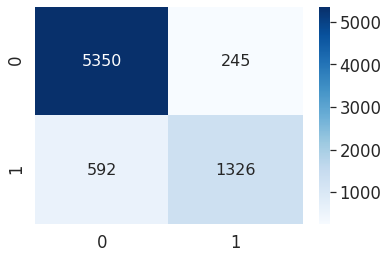

In [152]:
cm7 = confusion_matrix(Y_train_7, y_train_predict_7)
sns.heatmap(cm7, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' :16})

In [153]:
#added link counts
texts3 = train_copy['email']
words_improve = ['title', 'head', 'font size', 'url', 'charset', 'meta', 'below', 'click', 'align']
X_train_7 = pd.DataFrame(words_in_texts(words2, texts3))
X_train_7['email length'] = train_copy['email length']
X_train_7['title length'] = train_copy['title length']
X_train_7['Exclamation in title'] = train_copy['subject'].str.count("!")
X_train_7['Reply counts'] = train_copy['subject'].str.count("Re")
X_train_7['Uppercase in title'] = count_upper(train_copy['subject'])
X_train_7['Uppercase in email'] = count_upper(train_copy['email'])
X_train_7['dollar sign counts'] = train_copy['subject'].str.count('$')
X_train_7['link counts'] = train_copy['email'].str.count("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?")
Y_train_7 = train_copy['spam']
model7 = LogisticRegression()
model7.fit(X_train_7, Y_train_7)
y_train_predict_7 = model7.predict(X_train_7)
confusion_matrix_cal(Y_train_7, y_train_predict_7)

Accuracy:  0.8887262079062958
Precision:  0.8931686046511628
Recall:  0.6407716371220021
False positive rate:  0.026273458445040216
True positive rate:  0.026273458445040216


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
texts3 = train_copy['email']
words_improve = ['title', 'head', 'font size', 'url', 'charset', 'meta', 'below', 'click', 'align']
X_train_7 = pd.DataFrame(words_in_texts(words2, texts3))
X_train_7['title length'] = train_copy['title length']
X_train_7['Exclamation in title'] = train_copy['subject'].str.count("!")
X_train_7['Reply counts'] = train_copy['subject'].str.count("Re")
X_train_7['Uppercase in title'] = count_upper(train_copy['subject'])
X_train_7['Uppercase in email'] = count_upper(train_copy['email'])
X_train_7['dollar sign counts'] = train_copy['subject'].str.count('$')
X_train_7['link counts'] = train_copy['email'].str.count("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?")
X_train_7['orginals count'] = train_copy['email'].str.count('----- original message -----')
Y_train_7 = train_copy['spam']
model7 = LogisticRegression()
model7.fit(X_train_7, Y_train_7)
y_train_predict_7 = model7.predict(X_train_7)
confusion_matrix_cal(Y_train_7, y_train_predict_7)

Accuracy:  0.9097564222015174
Precision:  0.886052303860523
Recall:  0.7419186652763295
False positive rate:  0.032707774798927614
True positive rate:  0.032707774798927614


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [155]:
words_improve = ['|', '-', '{}', ']', '[', ':', '>', '<', '+', '"', '\\', '#', '@', 
                 '%', '$', '----- original message -----','blockquote', '3dcenter',
                 '3d4', '0000ff', 'removed' ,'bordercolor', 'title', 'head', 'font size', 
                 'url', 'charset', 'meta', 'below', 'click', 'align', 'href', '<body>', '<table>', '.org']

In [156]:
#This part is to try making functions to take the top x spam and ham words from all the emails
#first i have to remove all the punctuations
#second i have to separate spam and ham emails
#then i split every email with a separator(white space) to get a list of words
#then i put them all into two dictionaries, one for spam, one for ham

In [157]:
#remove all the punctuations
train_copy['list of words'] = train_copy['email without html'].str.replace(r'[^\w\s]', '')

In [158]:
#split into hams and spams
spams = train_copy[train_copy['type'] == 'spam']
hams = train_copy[train_copy['type'] == 'ham']

In [159]:
#this function creates a list of words from a column given
def splitting(column):
    arr = []
    for row in column:
        arr = arr + row.split(" ")
        arr.remove("")
    return arr

In [160]:
#this is getting the list of spam words
spams_words = splitting(spams['list of words'])

In [161]:
#this is getting the list of ham words
hams_words = splitting(hams['list of words'])

In [162]:
from collections import Counter
#function to put a list of words to a dictionary for word counting and sort it in descending
#because it is "" only.
spam_dict = dict(sorted((Counter(spams_words)).items(), key=lambda x: x[1], reverse=True))
ham_dict = dict(sorted((Counter(hams_words)).items(), key=lambda x: x[1], reverse=True))

In [163]:
#this is an alternative way to write the function, but it took a year to run, because runtime
#is O(n^n), so I changed to using the collections library instead
#def word_dict(array):
    #to_return = {x:array.count(x) for x in array}
    #return to_return

In [164]:
#getting the first x elements from both of the dictionaries, neglecting the first one because it is a "".
#in here I did 100, but will try other amount later
#now i did 500 words!!!
#update: not enough!!! 1000 words!!!
#imma try 2000 mwaahhahahaha!!!!
#i'm a terrible person and imma use 5000...
#oh no my kernel died, guess i'll try 3000
top_x_spam = list(spam_dict.keys())[1:3002]
top_x_ham = list(ham_dict.keys())[1:3002]

In [165]:
#Lastly, I use both top_x_spam and top_x_ham with my own list whic i obtain through mere 
#observation for the word choices on model7 (see cell 158)

In [166]:
#final version, removed some features and added some(original counts)
texts3 = train_copy['email'] #'credit','margin', 'ff0000'
words_improve = ['|', '-', '{}', ']', '[', ':', '>', '<', '+', '"', '\\', '#', '@', 
                 '%', '$', '----- original message -----','blockquote', '3dcenter',
                 '3d4', '0000ff', 'removed' ,'bordercolor', 'title', 'head', 'font size', 
                 'url', 'charset', 'meta', 'below', 'click', 'align', 'href', '<body>', '<table>', '.org']
X_train_final = pd.DataFrame(words_in_texts(top_x_spam + top_x_ham, texts3))
X_train_final['Exclamation in title'] = train_copy['subject'].str.count("!")
X_train_final['Reply counts'] = train_copy['subject'].str.count("Re")
X_train_final['Uppercase in title'] = count_upper(train_copy['subject'])
X_train_final['Uppercase in email'] = count_upper(train_copy['email'])
X_train_final['link counts'] = train_copy['email'].str.count("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?")

Y_train_final = train_copy['spam']
model_final = LogisticRegression()
model_final.fit(X_train_final, Y_train_final)
y_train_predict_final = model_final.predict(X_train_final)
confusion_matrix_cal(Y_train_final, y_train_predict_final)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  1.0
Precision:  1.0
Recall:  1.0
False positive rate:  0.0
True positive rate:  0.0


In [167]:
from sklearn.model_selection import KFold
from sklearn.base import clone
def cross_validate_accuracies(model):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    training_accuracies = []
    for tr_ind, va_ind in five_fold.split(X_train_final):
        model.fit(X_train_final.iloc[tr_ind,:], Y_train_final.iloc[tr_ind])
        y_predict = model.predict(X_train_final.iloc[tr_ind,:])
        training_accuracy = np.sum(y_predict == Y_train_final.iloc[tr_ind]) / len(Y_train_final.iloc[tr_ind])
        training_accuracies.append(training_accuracy)
    return training_accuracies

cross_validate_accuracies(model_final)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[1.0, 1.0, 1.0, 1.0, 1.0]

#words_improve = ['act','save','common','thu','kind','href','side',
                 'fast','comment','national','above','similar',
                 'coming','return','tired','advertise', 'cost','subscribe','various','ffcc99','|', '-', '{}', ']', 
                 '[', ':', '>', '<', '+', '"', '\\', '#', '@', '%', '$', '----- original message -----',
                 'blockquote','jul', '3dcenter','3d4', '0000ff', 'removed' ,'recent','important','bordercolor', 'title', 'head', 
                 'font size','political', 'url', 'charset', 'meta', 'below','preferences', 'click', 'align', '<body>', '<table>', '.org']

In [168]:
#function to transform the test data
#here i used model7 on this function to get a prediction on the test data set
def test_transform(test, model):
    words_improve = ['|', '-', '{}', ']', '[', ':', '>', '<', '+', '"', '\\', '#', '@', 
                 '%', '$', '----- original message -----','blockquote', '3dcenter',
                 '3d4', '0000ff', 'removed' ,'bordercolor', 'title', 'head', 'font size', 
                 'url', 'charset', 'meta', 'below', 'click', 'align', 'href', '<body>', '<table>', '.org']
    X_test = pd.DataFrame(words_in_texts(top_x_spam + top_x_ham, test['email']))
    #X_test['email length'] = test['email'].str.len()
    #X_test['title length'] = test['subject'].str.len()
    X_test['Exclamation in title'] = test['subject'].str.count("!")
    X_test['Reply counts'] = test['subject'].str.count("Re")
    X_test['Uppercase in title'] = count_upper(test['subject'])
    X_test['Uppercase in email'] = count_upper(test['email'])
    X_test['link counts'] = test['email'].str.count("(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?")
    y_test_predict = model.predict(X_test)
    return y_test_predict 

In [169]:
final_predict = test_transform(test, model_final)

In [170]:
train_copy['splited'] = train_copy['list of words'].str.split(" ")

#this function counts the most frequent string in each email
def count_freq(column):
    most_freq = []
    for row in column:
        word_dict = dict(sorted((Counter(row)).items(), key=lambda x: x[1], reverse=True))
        word_list = list(word_dict.keys())
        if '' in word_list:
            word_list.remove('')
        most_freq.append(word_list[0])
    return most_freq

train_copy['most frequent word'] = count_freq(train_copy['splited'])

<!-- BEGIN QUESTION -->

### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->

1.) I used the tendency of most spam emails in the format of html and adding words that are specifically in html tags(like head, font size, charset, meta) into the word list. But later I found out it is not enough to reach at least 88%, so I keep adding words that I observed when surfing throught the emails, and keep adding word to the list. It helped a bit and enough to reach 88%, however, I want to further improve it as much as possible to 100%. So instead of using my bare eyes to get a list of words, I try to implement a function to obtain a list of words with their counts. It turns out it improved my model a lot better, and I keep adding the amount of words I found through the function to my model and finally reached an accuracy of 100 in both my training data and through my cross validation process. Also, I try removing html tags and extract the words, turns out my accuracy got better, and it is my best accuracy out of all.

2.) At first I keep adding new features without really looking into them on whether they really define clearly emails to spam or ham. As I went back and look into the features I have added and created graphs to visualize them, I realize one of them, the counting of exclamation marks in emails, doesn't define well between the two classes, so I have decided to remove it, and the accuracy got better. It was the redundancy of data, like instead of adding a column for a count for a string, I found out addinf that string to my word list is actually better, so I removed as much as possible of those redundancies. I also found that getting a list of words manually is not enough to improve the accuracy, so at last I used a function I have created to help me get a better list of words.

3.) I am pretty surprised that punctuations are actually pretty good features, my accuracies kept increasing as I kept adding them into my word list. Also, as I am suspecting a lot of features that could mostly be found in spam emails, such as html tags, it turns out they could be found more often in ham emails, and I was surprised to find out that. 

<!-- END QUESTION -->



### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->

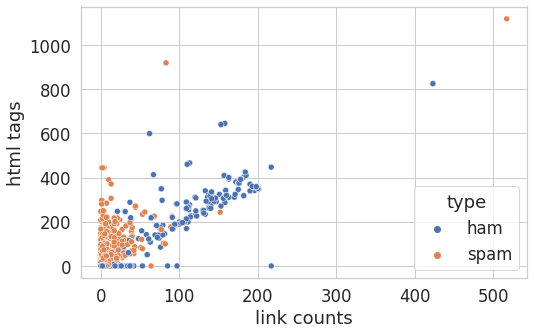

In [173]:
# Write your description (2-3 sentences) as a comment here:
# In the graph below, it looks like there are some correlation between links counts and html tags.
# The correlation is strong for some ham emails with some outliers
#In the case for spam emails, there might be some correlation but it is not as strong as for ham emails.

# Write the code to generate your visualization here:

top_10_spam = list(spam_dict.keys())[1:11]
top_10_ham = list(ham_dict.keys())[1:11]
top_10_spam[0] = "next line"
top_10_ham[0] = "next line"
spam_type = ['spam']*10
spam_d = {'words': top_10_spam, 'count': list(spam_dict.values())[1:11], 'type' : spam_type}
spam_words_data = pd.DataFrame(data = spam_d)
ham_type = ['ham']*10
ham_d = {'words': top_10_ham, 'count': list(ham_dict.values())[1:11], 'type' : ham_type}
ham_words_data = pd.DataFrame(data = ham_d)
word_data= pd.concat([ham_words_data, spam_words_data])
plt.figure(figsize=(8, 5))
sns.scatterplot(x = "link counts", y = "html tags", data = train_copy, hue = "type")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 9: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 19 or [Section 17.7](https://www.textbook.ds100.org/ch/17/classification_sensitivity_specificity.html) of the course text to see how to plot an ROC curve.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->

1.0

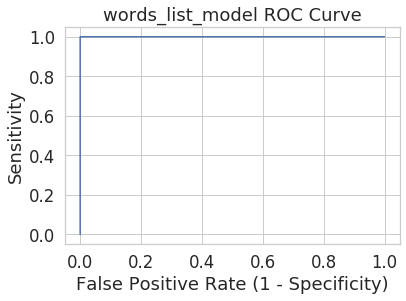

In [174]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

y_train_predict_proba = model_final.predict_proba(X_train_final)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(Y_train_final, y_train_predict_proba, pos_label=1)
plt.step(false_positive_rate_values, sensitivity_values, color='b', where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('words_list_model ROC Curve')
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_train_final, y_train_predict_proba)

<!-- END QUESTION -->

# Question 10: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project 2 Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope. Your public Gradescope results are based off of your classifier's accuracy on 70% of the test dataset and your score for this question will be based off of your classifier's accuracy on 100% of the test set.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 3
-->

In [175]:
test_predictions = final_predict

In [176]:
grader.check("q10")

All tests passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project 2 Test Predictions" assignment on Gradescope to get credit for this question.**

In [177]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2020-11-30T14:07:39.csv.
You may now upload this CSV file to Gradescope for scoring.


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [178]:
grader.check_all()

q10:

    All tests passed!
    

q1a:

    All tests passed!
    

q1b:

    All tests passed!
    

q2:

    All tests passed!
    

q4:

    All tests passed!
    

q5:

    All tests passed!
    

q6a:

    All tests passed!
    

q6b:

    All tests passed!
    

q6d:

    All tests passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export("proj2.ipynb")